In [1]:
%reload_ext autoreload
%autoreload 2

In [58]:
import argparse

import numpy as np
import stheno.torch as stheno
import torch
from tqdm.auto import tqdm
from tensorboardX import SummaryWriter
import convcnp.data
from convcnp.architectures import SimpleConv, UNet
from convcnp.cnp import RegressionANP as ANP
from convcnp.cnp import RegressionCNP as CNP
from convcnp.experiment import (
    report_loss,
    RunningAverage,
    generate_root,
    WorkingDirectory,
    save_checkpoint
)
from convcnp.set_conv import ConvCNP
from convcnp.utils import device, gaussian_logpdf



In [66]:


def validate(data, model, report_freq=None):
    """Compute the validation loss."""
    ravg = RunningAverage()
    model.eval()
    with torch.no_grad():
        for step, task in enumerate(data):
            y_mean, y_std = \
                model(task['x_context'], task['y_context'], task['x_target'])
            obj = \
                -gaussian_logpdf(task['y_target'], y_mean, y_std,
                                 'batched_mean')
            ravg.update(obj.item() / data.batch_size, data.batch_size)
            if report_freq:
                report_loss('Validation', ravg.avg, step, report_freq)
    return ravg.avg


def train(data, model, opt, report_freq):
    """Perform a training epoch."""
    ravg = RunningAverage()
    model.train()
    for step, task in enumerate(data):
        y_mean, y_std = model(task['x_context'], task['y_context'],
                              task['x_target'])
        obj = -gaussian_logpdf(task['y_target'], y_mean, y_std, 'batched_mean')
        obj.backward()
        opt.step()
        opt.zero_grad()
        ravg.update(obj.item() / data.batch_size, data.batch_size)
        report_loss('Training', ravg.avg, step, report_freq)
    return ravg.avg


In [75]:
from matplotlib import pyplot as plt
def to_numpy(x):
    """Convert a PyTorch tensor to NumPy."""
    return x.squeeze().detach().cpu().numpy()


def plot(gen, model, name):
    # Make prediction
    task = next(iter(gen))

    x_context = task['x_context'][:1]
    y_context = task['y_context'][:1]
    x_target = task['x_target'][:1]
    y_target = task['y_target'][:1]
    x_all = task['x'][:1]
    y_all = task['y'][:1]


    y_mean, y_std = model(x_context, y_context,
                                  x_target)

    
    # sort target for pred & plotting
    inds_target = torch.argsort(x_target.squeeze())
    x_target = x_target[:, inds_target]
    y_target = y_target[:, inds_target]
    y_mean = y_mean[:, inds_target]
    y_std = y_std[:, inds_target]

    # Plot context set.
    plt.scatter(to_numpy(x_target), to_numpy(y_target), label='Target Set', s=20, color='grey', alpha=0.5)
    plt.scatter(to_numpy(x_context), to_numpy(y_context), label='Context Set', color='black')    
    plt.plot(to_numpy(x_all), to_numpy(y_all), '--',  label='Sampled function', color='gray', alpha=0.9)

    # Plot model predictions.
    plt.plot(to_numpy(x_target), to_numpy(y_mean), label='%s Output' % name, color='blue')
    plt.fill_between(to_numpy(x_target),
                     to_numpy(y_mean + 1 * y_std),
                     to_numpy(y_mean - 1 * y_std),
                     color='tab:blue', alpha=0.2)
    plt.ylim(-3., 3)
    plt.axis('off')
    plt.legend()
    plt.show()

In [71]:


# Parse arguments given to the script.
parser = argparse.ArgumentParser()
parser.add_argument('data',
                    choices=['eq',
                             'matern',
                             'noisy-mixture',
                             'weakly-periodic',
                             'sawtooth'],
                    help='Data set to train the CNP on. ')
parser.add_argument('model',
                    choices=['convcnp', 'convcnpxl', 'cnp', 'anp'],
                    help='Choice of model. ')
parser.add_argument('--root',
                    help='Experiment root, which is the directory from which '
                         'the experiment will run. If it is not given, '
                         'a directory will be automatically created.')
parser.add_argument('--train',
                    action='store_true',
                    help='Perform training. If this is not specified, '
                         'the model will be attempted to be loaded from the '
                         'experiment root.')
parser.add_argument('--epochs',
                    default=100,
                    type=int,
                    help='Number of epochs to train for.')
parser.add_argument('--learning_rate',
                    default=1e-3,
                    type=float,
                    help='Learning rate.')
parser.add_argument('--weight_decay',
                    default=1e-5,
                    type=float,
                    help='Weight decay.')
args = parser.parse_args(['noisy-mixture', 'convcnp', '--train', '--epochs','500'])

In [72]:

# Load working directory.
if args.root:
    wd = WorkingDirectory(root=args.root)
else:
    experiment_name = f'{args.model}-{args.data}'
    wd = WorkingDirectory(root=generate_root(experiment_name))

# Load data generator.
if args.data == 'sawtooth':
    gen = convcnp.data.SawtoothGenerator()
    gen_val = convcnp.data.SawtoothGenerator(num_tasks=60)
    gen_test = convcnp.data.SawtoothGenerator(num_tasks=2048)
else:
    if args.data == 'eq':
        kernel = stheno.EQ().stretch(0.25)
    elif args.data == 'matern':
        kernel = stheno.Matern52().stretch(0.25)
    elif args.data == 'noisy-mixture':
        kernel = stheno.EQ().stretch(1.) + \
                 stheno.EQ().stretch(.25) + \
                 0.001 * stheno.Delta()
    elif args.data == 'weakly-periodic':
        kernel = stheno.EQ().stretch(0.5) * stheno.EQ().periodic(period=0.25)
    else:
        raise ValueError(f'Unknown data "{args.data}".')

    gen = convcnp.data.GPGenerator(kernel=kernel)
    gen_val = convcnp.data.GPGenerator(kernel=kernel, num_tasks=60)
    gen_test = convcnp.data.GPGenerator(kernel=kernel, num_tasks=2048)

# Load model.
if args.model == 'convcnp':
    model = ConvCNP(learn_length_scale=True,
                    points_per_unit=64,
                    architecture=SimpleConv())
elif args.model == 'convcnpxl':
    model = ConvCNP(learn_length_scale=True,
                    points_per_unit=64,
                    architecture=UNet())
elif args.model == 'cnp':
    model = CNP(latent_dim=128)
elif args.model == 'anp':
    model = ANP(latent_dim=128)
else:
    raise ValueError(f'Unknown model {args.model}.')

model.to(device)

# Perform training.
opt = torch.optim.Adam(model.parameters(),
                       args.learning_rate,
                       weight_decay=args.weight_decay)

writer = SummaryWriter(wd.root)

Root: _experiments/2020-02-02_11-28-14_convcnpxl-noisy-mixture


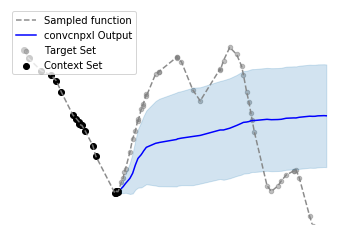


Epoch: 1/500
Training            1: 2.471e+00
Training        epoch: 2.447e+00
Validation          1: 4.781e-01
Validation      epoch: 2.845e+00


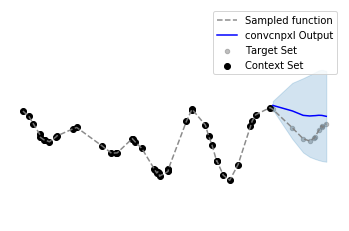


Epoch: 2/500
Training            1: 4.406e+00
Training        epoch: 2.534e+00
Validation          1: 3.291e+00
Validation      epoch: 2.806e+00

Epoch: 3/500
Training            1: 3.401e+00
Training        epoch: 2.557e+00
Validation          1: 1.292e+00
Validation      epoch: 2.772e+00

Epoch: 4/500
Training            1: 2.842e+00
Training        epoch: 2.576e+00
Validation          1: 3.556e+00
Validation      epoch: 2.391e+00

Epoch: 5/500
Training            1: 7.803e-01
Training        epoch: 2.415e+00
Validation          1: 3.174e+00
Validation      epoch: 2.657e+00

Epoch: 6/500
Training            1: 3.948e+00
Training        epoch: 2.524e+00
Validation          1: 2.069e+00
Validation      epoch: 2.439e+00

Epoch: 7/500
Training            1: 3.960e+00
Training        epoch: 2.580e+00
Validation          1: 3.747e+00
Validation      epoch: 2.523e+00

Epoch: 8/500
Training            1: 4.327e+00
Training        epoch: 2.519e+00
Validation          1: 3.717e+00
Validation 

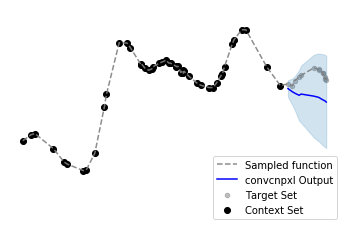


Epoch: 12/500
Training            1: 5.173e+00
Training        epoch: 2.403e+00
Validation          1: 7.745e-01
Validation      epoch: 2.225e+00

Epoch: 13/500
Training            1: 3.020e+00
Training        epoch: 2.650e+00
Validation          1: 3.289e-01
Validation      epoch: 2.423e+00

Epoch: 14/500
Training            1: 5.349e-01
Training        epoch: 2.416e+00
Validation          1: 2.234e+00
Validation      epoch: 2.538e+00

Epoch: 15/500
Training            1: 3.466e+00
Training        epoch: 2.580e+00
Validation          1: 2.483e+00
Validation      epoch: 2.682e+00

Epoch: 16/500
Training            1: 4.923e+00
Training        epoch: 2.609e+00
Validation          1: 1.689e+00
Validation      epoch: 2.575e+00

Epoch: 17/500
Training            1: 1.698e+00
Training        epoch: 2.493e+00
Validation          1: 3.137e+00
Validation      epoch: 2.622e+00

Epoch: 18/500
Training            1: 2.686e-01
Training        epoch: 2.492e+00
Validation          1: 2.958e+00
Vali

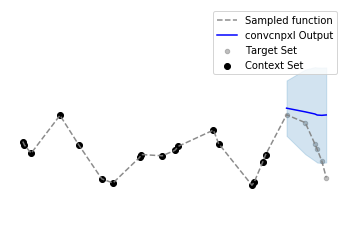


Epoch: 22/500
Training            1: 1.123e+00
Training        epoch: 2.502e+00
Validation          1: 2.745e+00
Validation      epoch: 2.290e+00

Epoch: 23/500
Training            1: 2.128e-01
Training        epoch: 2.424e+00
Validation          1: 3.168e+00
Validation      epoch: 2.628e+00

Epoch: 24/500
Training            1: 1.805e+00
Training        epoch: 2.442e+00
Validation          1: 1.958e+00
Validation      epoch: 2.457e+00

Epoch: 25/500
Training            1: 2.554e+00
Training        epoch: 2.484e+00
Validation          1: 3.798e+00
Validation      epoch: 2.488e+00

Epoch: 26/500
Training            1: 4.084e+00
Training        epoch: 2.485e+00
Validation          1: 1.843e-01
Validation      epoch: 2.535e+00

Epoch: 27/500
Training            1: 2.089e+00
Training        epoch: 2.388e+00
Validation          1: 3.292e-01
Validation      epoch: 2.691e+00

Epoch: 28/500
Training            1: 1.656e+00
Training        epoch: 2.399e+00
Validation          1: 4.152e+00
Vali

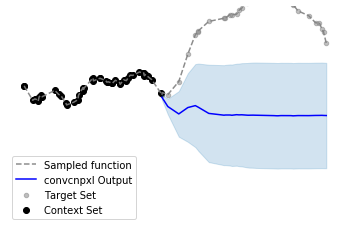


Epoch: 32/500
Training            1: 1.034e+00
Training        epoch: 2.427e+00
Validation          1: 8.345e-01
Validation      epoch: 2.201e+00

Epoch: 33/500
Training            1: 1.693e+00
Training        epoch: 2.556e+00
Validation          1: 3.479e+00
Validation      epoch: 2.502e+00

Epoch: 34/500
Training            1: 1.931e+00
Training        epoch: 2.592e+00
Validation          1: 5.081e+00
Validation      epoch: 2.866e+00

Epoch: 35/500
Training            1: 1.237e-01
Training        epoch: 2.545e+00
Validation          1: 2.187e+00
Validation      epoch: 2.419e+00

Epoch: 36/500
Training            1: 1.983e+00
Training        epoch: 2.428e+00
Validation          1: 1.600e+00
Validation      epoch: 2.558e+00

Epoch: 37/500
Training            1: 1.917e+00
Training        epoch: 2.579e+00
Validation          1: 3.300e+00
Validation      epoch: 2.541e+00

Epoch: 38/500
Training            1: 4.043e+00
Training        epoch: 2.519e+00
Validation          1: 2.558e+00
Vali

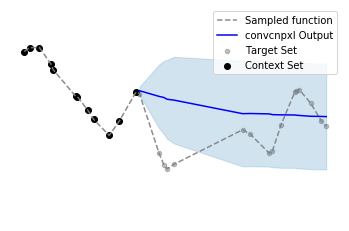


Epoch: 42/500
Training            1: 4.030e+00
Training        epoch: 2.304e+00
Validation          1: 3.739e+00
Validation      epoch: 2.526e+00

Epoch: 43/500
Training            1: 4.031e+00
Training        epoch: 2.575e+00
Validation          1: 2.848e+00
Validation      epoch: 2.360e+00

Epoch: 44/500
Training            1: 3.065e+00
Training        epoch: 2.480e+00
Validation          1: 1.181e+00
Validation      epoch: 2.729e+00

Epoch: 45/500
Training            1: 4.170e+00
Training        epoch: 2.617e+00
Validation          1: 4.325e+00
Validation      epoch: 2.463e+00

Epoch: 46/500
Training            1: 1.987e+00


In [ ]:

plot(gen, model, args.model)

if args.train:
    # Run the training loop, maintaining the best objective value.
    best_obj = np.inf
    for epoch in tqdm(range(args.epochs)):
        print('\nEpoch: {}/{}'.format(epoch + 1, args.epochs))

        # Compute training objective.
        train_obj = train(gen, model, opt, report_freq=500)
        report_loss('Training', train_obj, 'epoch')
        writer.add_scalar('train/loss', val_obj, epoch)

        # Compute validation objective.
        val_obj = validate(gen_val, model, report_freq=200)
        report_loss('Validation', val_obj, 'epoch')
        writer.add_scalar('val/loss', val_obj, epoch)
        
        if epoch%10==0:
            plot(gen_val, model, args.model)

        # Update the best objective value and checkpoint the model.
        is_best = False
        if val_obj < best_obj:
            best_obj = val_obj
            is_best = True
        save_checkpoint(wd,
                        {'epoch': epoch + 1,
                         'state_dict': model.state_dict(),
                         'best_acc_top1': best_obj,
                         'optimizer': opt.state_dict()},
                        is_best=is_best)
else:
    # Load saved model.
    load_dict = torch.load(wd.file('model_best.pth.tar', exists=True))
    model.load_state_dict(load_dict['state_dict'])


In [ ]:
# Finally, test model on ~2000 tasks.
test_obj = validate(gen_test, model)
print('Model averages a log-likelihood of %s on unseen tasks.' % -test_obj)
with open(wd.file('test_log_likelihood.txt'), 'w') as f:
    f.write(str(-test_obj))


# Scratch

In [ ]:
gen = convcnp.data.GPGenerator(kernel=kernel)
gen_val = convcnp.data.GPGenerator(kernel=kernel, num_tasks=60)
gen_test = convcnp.data.GPGenerator(kernel=kernel, num_tasks=2048)

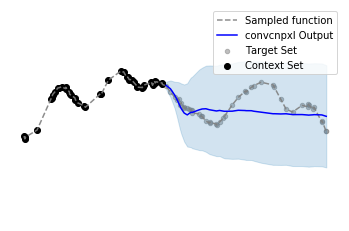

In [101]:
plot(gen, model, args.model)